In [1]:
import pandas as pd 
import nltk 
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt 
import seaborn as sn 
import re 
import joblib as jb # to save the model 

In [21]:
#nltk.download() if you have done this before skip this part 

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml
showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml
showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


True

## Data Processing 

In [3]:
text = pd.read_csv('spam.csv',encoding='latin-1') # change according to the file type 

In [4]:
text.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [5]:
text = text.drop(['Unnamed: 2','Unnamed: 3','Unnamed: 4'],axis=1)

In [6]:
text.columns = ['spam_or_not','text']

In [7]:
text.spam_or_not.value_counts()

ham     4825
spam     747
Name: spam_or_not, dtype: int64

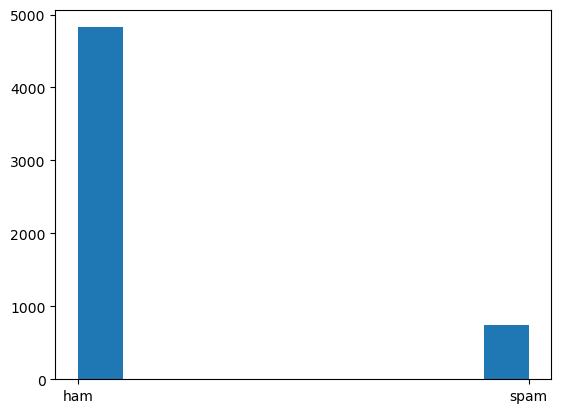

In [8]:
plt.hist(text['spam_or_not'])
plt.show()

In [9]:
spam=pd.get_dummies(text['spam_or_not'])
spam.head()

,ham,spam
0,1,0
1,1,0
2,0,1
3,1,0
4,1,0


In [10]:
text['spam']=spam.spam
text=text.drop(['spam_or_not'],axis=1)

In [11]:
text.head()

,text,spam
0,"Go until jurong point, crazy.. Available only ...",0
1,Ok lar... Joking wif u oni...,0
2,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,U dun say so early hor... U c already then say...,0
4,"Nah I don't think he goes to usf, he lives aro...",0


In [12]:
text['spam'].value_counts()

0    4825
1     747
Name: spam, dtype: int64

In [13]:
text.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    5572 non-null   object
 1   spam    5572 non-null   uint8 
dtypes: object(1), uint8(1)
memory usage: 49.1+ KB


In [31]:
from wordcloud import WordCloud
def plot_wordcloud(text, mask=None, max_words=200, max_font_size=100, figure_size=(24.0,16.0), 
                   title = None, title_size=40, image_color=False):
    Stopwords = stopwords.words('english')

    wordcloud = WordCloud(background_color='black',
                    stopwords = Stopwords,
                    max_words = max_words,
                    max_font_size = max_font_size, 
                    random_state = 42,
                    width=800, 
                    height=400,
                    mask = mask)
    wordcloud.generate(str(text))
    
    plt.figure(figsize=figure_size)
    if image_color:
        image_colors = ImageColorGenerator(mask);
        plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear");
        plt.title(title, fontdict={'size': title_size,  
                                  'verticalalignment': 'bottom'})
    else:
        plt.imshow(wordcloud);
        plt.title(title, fontdict={'size': title_size, 'color': 'black', 
                                  'verticalalignment': 'bottom'})
    plt.axis('off');
    plt.tight_layout()  

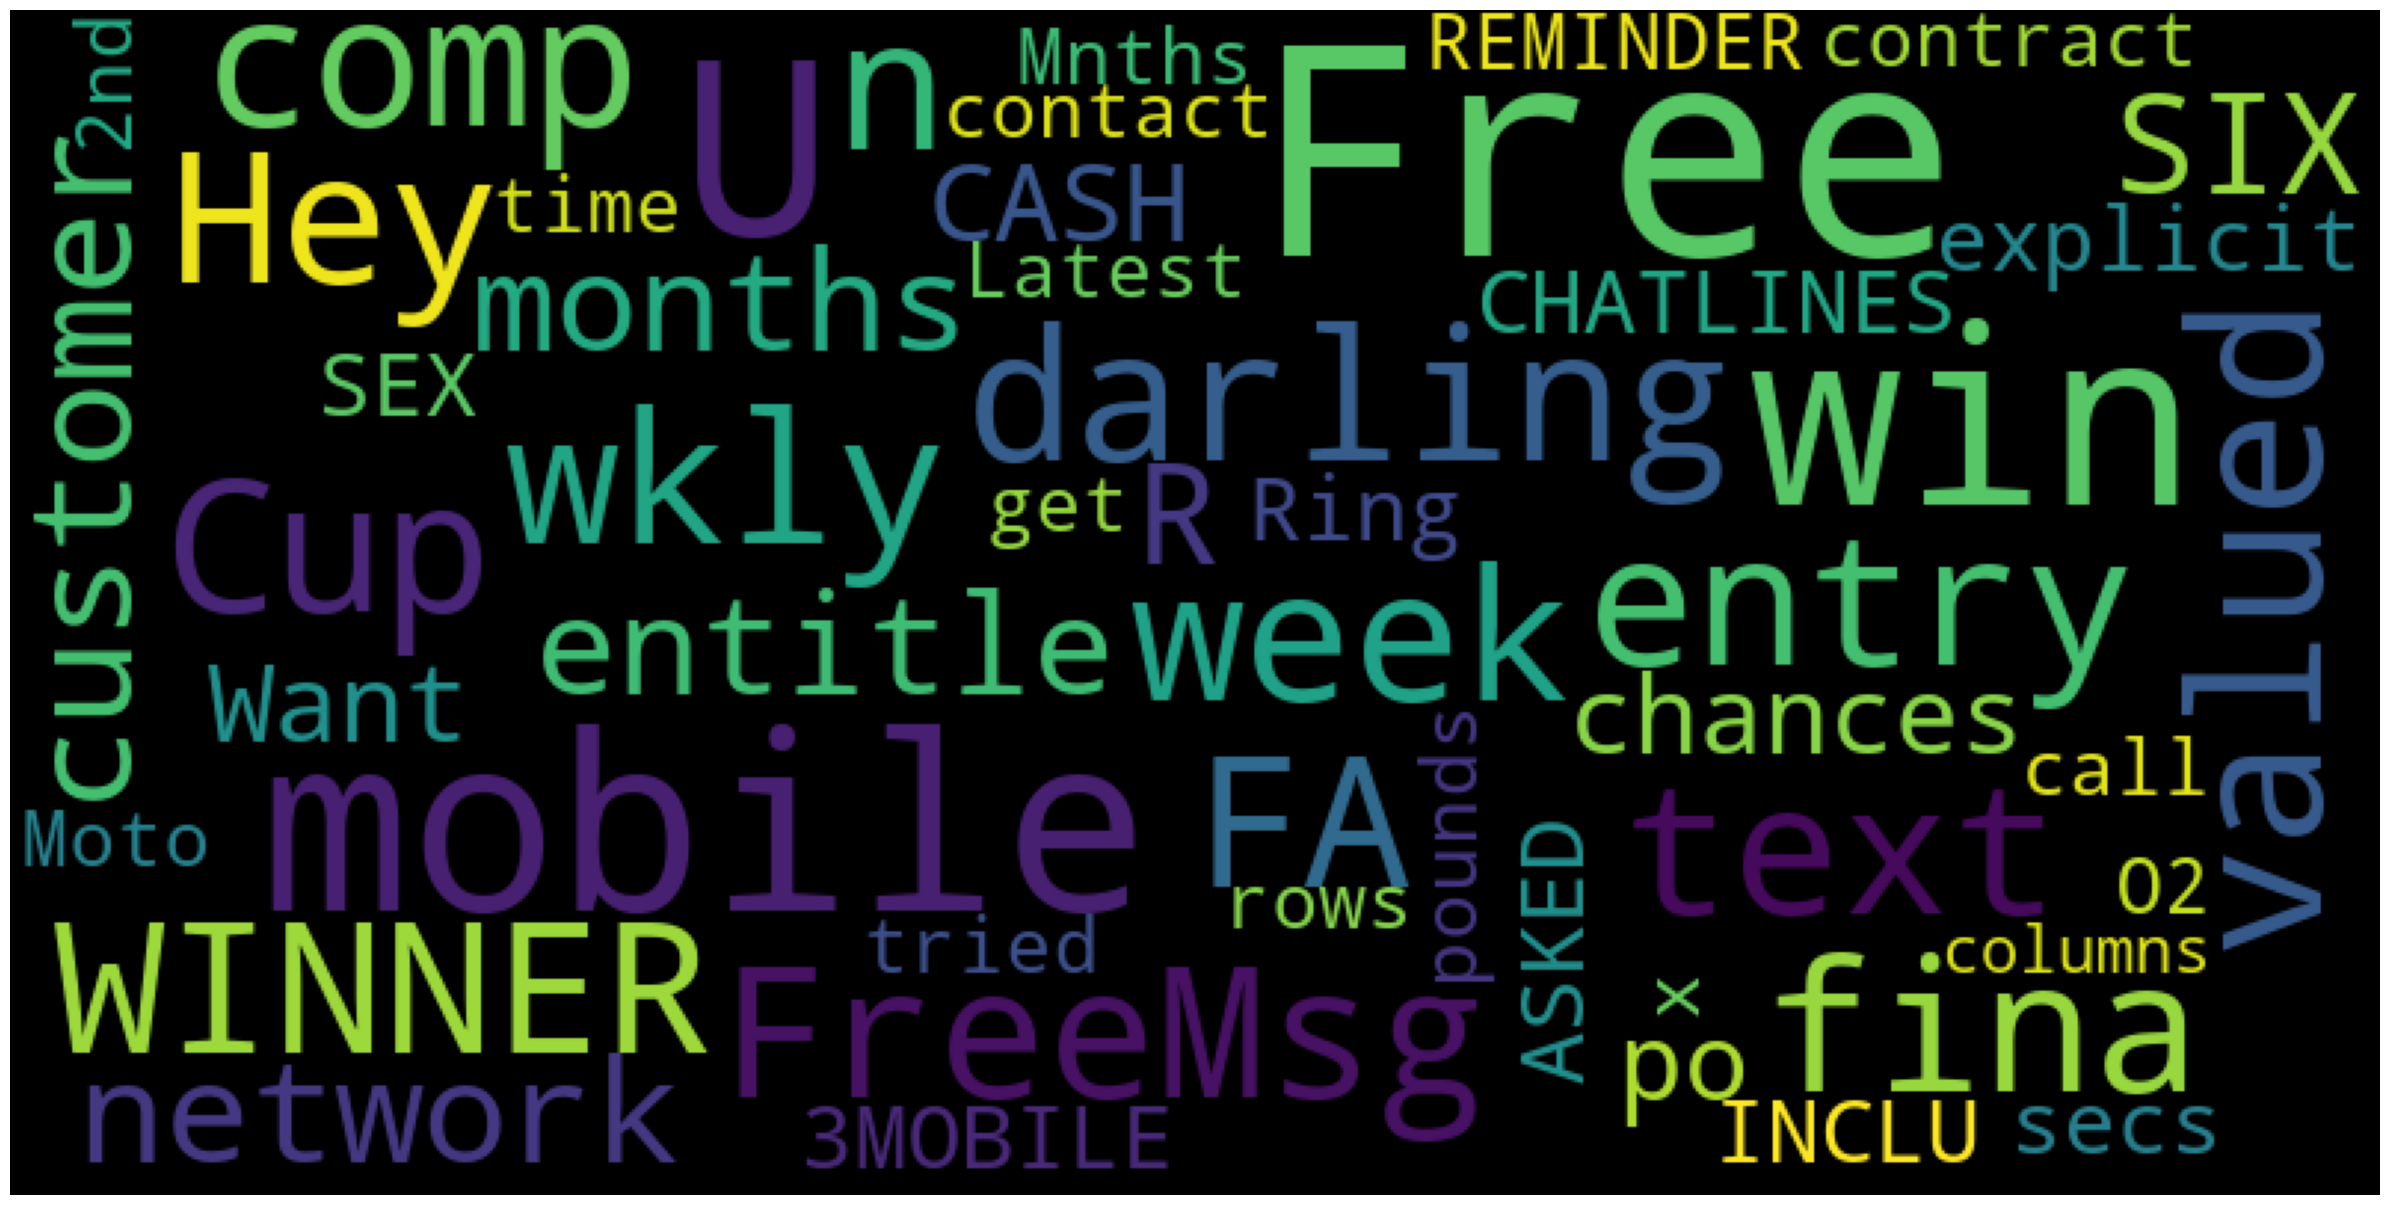

In [15]:
spam_email = text.loc[text['spam']==1,['text']]
plot_wordcloud(spam_email)

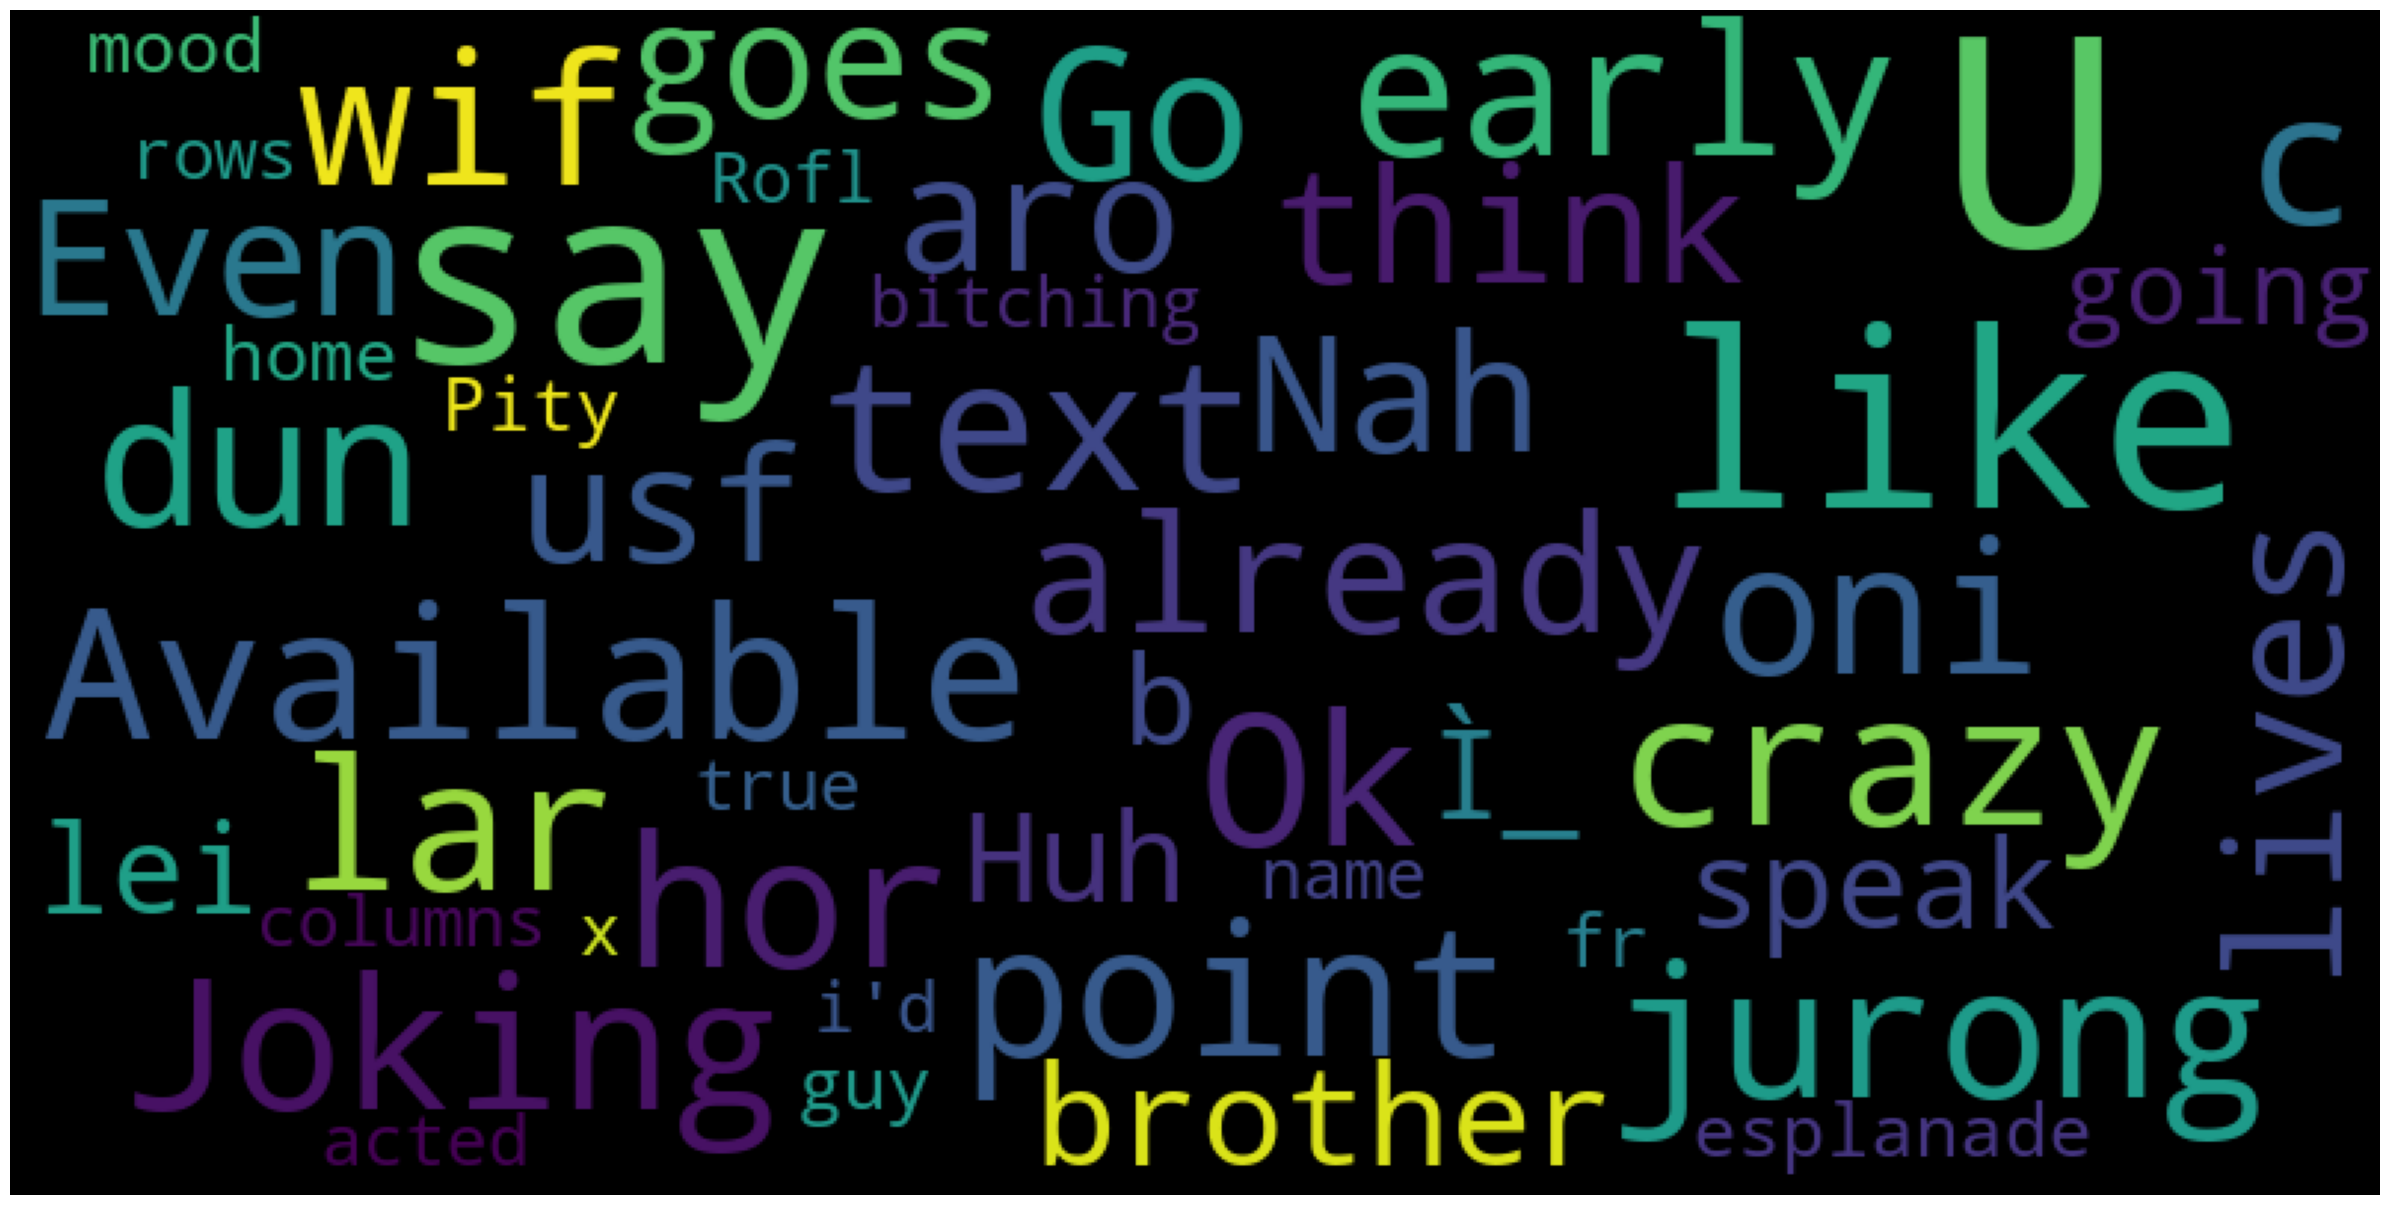

In [16]:
non_spam_email =text.loc[text['spam']==0,['text']]
plot_wordcloud(non_spam_email)

In [17]:
text.text

0       Go until jurong point, crazy.. Available only ...
1                           Ok lar... Joking wif u oni...
2       Free entry in 2 a wkly comp to win FA Cup fina...
3       U dun say so early hor... U c already then say...
4       Nah I don't think he goes to usf, he lives aro...
                              ...                        
5567    This is the 2nd time we have tried 2 contact u...
5568                Will Ì_ b going to esplanade fr home?
5569    Pity, * was in mood for that. So...any other s...
5570    The guy did some bitching but I acted like i'd...
5571                           Rofl. Its true to its name
Name: text, Length: 5572, dtype: object

In [14]:
stemming=PorterStemmer()#stemming process(similar to base words) 

In [15]:
filtered_text=[]
for i in range(len(text)):
    sentence_preprocessing = re.sub('[^a-zA-z]',' ',text.text[i])
    sentence_preprocessing = sentence_preprocessing.lower()
    sentence_preprocessing = sentence_preprocessing.split()

    sec_processed=[]
    for word in sentence_preprocessing:
        if word not in stopwords.words('english'): # to remove puntuations 
            stem_word=stemming.stem(word)
            sec_processed.append(stem_word)
#             sec_processed.append(word)

            
    #OR we can also use below code 
    #sec_processed = [stemming.stem(word) for word in sentence_preprocessing if word not in stopwords.words('english')]
       
            
    sentence_preprocessing = ' '.join(sec_processed)    
    filtered_text.append(sentence_preprocessing)

In [16]:
text.rename(columns={'spam':'Spam_Ham'},inplace=True)

In [17]:
text['filtered_text'] = filtered_text
text.head()

,text,Spam_Ham,filtered_text
0,"Go until jurong point, crazy.. Available only ...",0,go jurong point crazi avail bugi n great world...
1,Ok lar... Joking wif u oni...,0,ok lar joke wif u oni
2,Free entry in 2 a wkly comp to win FA Cup fina...,1,free entri wkli comp win fa cup final tkt st m...
3,U dun say so early hor... U c already then say...,0,u dun say earli hor u c alreadi say
4,"Nah I don't think he goes to usf, he lives aro...",0,nah think goe usf live around though


In [18]:
vectorizer= TfidfVectorizer(input = 'english')

In [19]:
text['Spam_Ham'].value_counts()

0    4825
1     747
Name: Spam_Ham, dtype: int64

In [20]:
x_train,x_test,y_train,y_test = train_test_split(text['filtered_text'],text['Spam_Ham'],test_size=0.2, random_state=10)

In [21]:
x_train_transform= vectorizer.fit_transform(x_train)
x_test_transform  = vectorizer.transform(x_test)

In [22]:
x_train.head()

5281                                             princess
1300    cocksuck make feel better ipad worthless garba...
5128                                     wot wed nite til
1808    aiyo bit pai seh _ noe scare dun rem die hee b...
856                                          go take babe
Name: filtered_text, dtype: object

## Model Building 

### Logistic Regression 

In [23]:
l_model=LogisticRegression()
l_model.fit(x_train_transform,y_train)
y_predict_l=l_model.predict(x_test_transform)

### Random Forest 

In [24]:
Randomforest_model = RandomForestClassifier()
Randomforest_model.fit(x_train_transform,y_train)
y_predict_r=Randomforest_model.predict(x_test_transform)

### XGBoost 

In [25]:
xgb_model = XGBClassifier()
xgb_model.fit(x_train_transform,y_train)
y_predict_xgb=xgb_model.predict(x_test_transform)

## Model Evaluation 

### Accuracy

In [26]:
print('accuracy of logistic regression model on testing data',l_model.score(x_test_transform,y_test))
print('accuracy of Randomforest model on testing data',Randomforest_model.score(x_test_transform,y_test))
print('accuracy of XGBoost model on testing data',xgb_model.score(x_test_transform,y_test))

accuracy of logistic regression model on testing data 0.9614349775784753
accuracy of Randomforest model on testing data 0.9748878923766816
accuracy of XGBoost model on testing data 0.9775784753363229


### Confusion Matrix

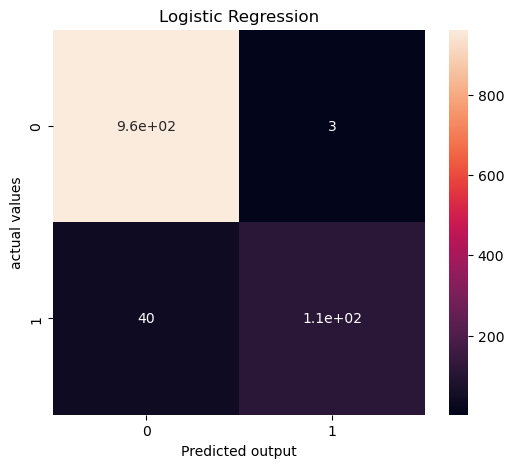

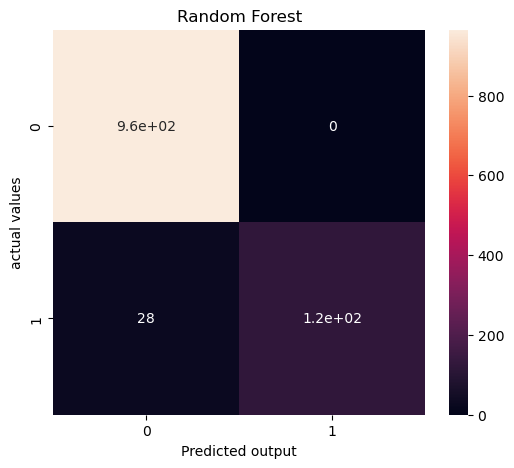

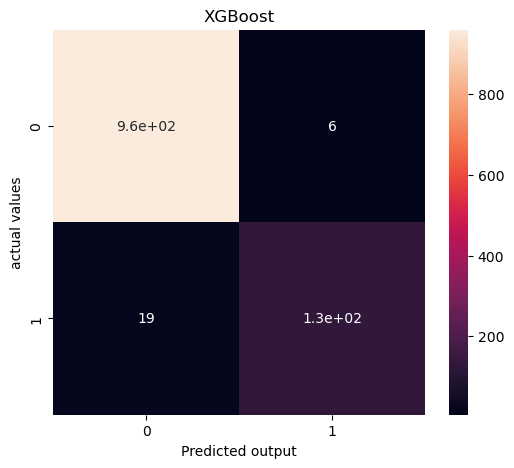

In [27]:
confusion_matrix_logistic =confusion_matrix(y_test,y_predict_l)

confusion_matrix_randomforest =confusion_matrix(y_test,y_predict_r)

confusion_matrix_xgboost =confusion_matrix(y_test,y_predict_xgb)

plt.figure(figsize=(6,5))
sn.heatmap(confusion_matrix_logistic, annot= True)
plt.title('Logistic Regression')
plt.xlabel("Predicted output")
plt.ylabel("actual values")
plt.show()

plt.figure(figsize=(6,5))
sn.heatmap(confusion_matrix_randomforest, annot= True)
plt.title('Random Forest')
plt.xlabel("Predicted output")
plt.ylabel("actual values")
plt.show()


plt.figure(figsize=(6,5))
sn.heatmap(confusion_matrix_xgboost, annot= True)
plt.title('XGBoost')
plt.xlabel("Predicted output")
plt.ylabel("actual values")
plt.show()

### F1 Score

#### logistic regression

In [28]:
pd.DataFrame(classification_report(y_test,y_predict_l, output_dict = True)).transpose()

,precision,recall,f1-score,support
0,0.960080,0.996891,0.978139,965.000000
1,0.973451,0.733333,0.836502,150.000000
accuracy,0.961435,0.961435,0.961435,0.961435
macro avg,0.966766,0.865112,0.907321,1115.000000
weighted avg,0.961879,0.961435,0.959085,1115.000000


#### Random Forest Regression

In [29]:
pd.DataFrame(classification_report(y_test,y_predict_r, output_dict = True)).transpose()

,precision,recall,f1-score,support
0,0.971803,1.000000,0.985700,965.000000
1,1.000000,0.813333,0.897059,150.000000
accuracy,0.974888,0.974888,0.974888,0.974888
macro avg,0.985901,0.906667,0.941379,1115.000000
weighted avg,0.975596,0.974888,0.973775,1115.000000


#### XGBoost

In [30]:
pd.DataFrame(classification_report(y_test,y_predict_xgb, output_dict = True)).transpose()

,precision,recall,f1-score,support
0,0.980573,0.993782,0.987133,965.000000
1,0.956204,0.873333,0.912892,150.000000
accuracy,0.977578,0.977578,0.977578,0.977578
macro avg,0.968388,0.933558,0.950013,1115.000000
weighted avg,0.977294,0.977578,0.977146,1115.000000


In [ ]:
## From Classification report and confusion matrix we can see that xgboost is performing better compared to other models

## Saving models and transformation 

In [79]:
jb.dump(vectorizer,'Text_Spam_detection_transformation')

['Text_Spam_detection_transformation']

In [80]:
jb.dump(l_model,'Text_Spam_detection_Logisticmodel')
jb.dump(Randomforest_model,'Text_Spam_detection_Randomforestmodel')
jb.dump(xgb_model,'Text_Spam_detection_Xgboostmodel')

['Text_Spam_detection_Xgboostmodel']

## prediction testing 

In [31]:
l_model

TfidfVectorizer(input='english')

In [ ]:
xgb_model

In [67]:
def sentence_processing(sentence):
    filtered_sentence = re.sub('[^a-zA-z]',' ',sentence).lower().split()
    filtered_sentence = [stemming.stem(word) for word in filtered_sentence if word not in stopwords.words('english')]
    filtered_sentence = ' '.join(filtered_sentence)
    
    return filtered_sentence


def word_vec(fil_sentence):
#     vectorizer = jb.load('Text_Spam_detection_transformation')
    vector = vectorizer.transform([testing])
    
    return vector 


def predict(sentence):
#     l_model = jb.load('Text_Spam_detection_Xgboostmodel')
    
    y_pred = sentence_processing(sentence)
    y_pred = word_vec(y_pred)
    
    y_pred = xgb_model.predict(y_pred)
    
    
    return y_pred
    

'histori'

In [78]:
testing = "Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's"
g = predict(testing)
g[0]

1